## **`Question 2.1`**
In this question, we will focus only on two information: total reviews per day with review time
(newtime from the dataframe) to form the review volume time series**`(from review.csv of user information we have to consider text or rating not num_of_reviews from meta data then only we will able to see its revew per day because in meta data its total review given)`**. You are required to explore the review
time series. There are some days not available in the review time series. Please add those days into the review
time series with default number of review with the mean value of the number of review per day in the whole
data (without any filtering on reviews). After that, decompose the submission review time series with
addictive mode and analyses on the results to find if there is any seasonality pattern (you could leverage the
M05A material from lab session with default setting in seasonal_decompose function). Please also include
your analysis details and implementation in the report.

### **Step 1:** Data Acquisition and dowloading.

In [1]:
#----------------------------Mount Google Drive to access files and data within Colab environment----------------------------#
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
#----------------------------Import essential data processing and visualization libraries;-----------------------------------#
#---------------------------  verify successful import with confirmation message---------------------------------------------#

try:
  import pandas as pd
  import numpy as np
  import matplotlib.pyplot as plt
  import pyspark

  print("="*100)
  print("Successfully import packages for data processing visualization")
  print("="*100)

except ImportError:
    print("Import Error")

##--------------------------- Import necessary libraries for handling zip files and-----------------------------------------#
##----------------------------Google Colab file operations with import verification-----------------------------------------#

try:
  import zipfile
  from google.colab import files
  import os
  print("="*100)
  print("Successfully import of file related packages")
  print("="*100)

except ImportError:
    print("Could not able to import files from googel colab")


Successfully import packages for data processing visualization
Successfully import of file related packages


In [3]:
# ------------------------------Upload your zip file from local system --------------------------------------------------#
print("Please upload your zip file containing review and metadata files...!")
uploaded = files.upload()

#------------------------------ Get the uploaded zip file name------------------------------------------------------------#
zip_filename=list(uploaded.keys())[0]
print(f"uploaded file = {zip_filename}")

Please upload your zip file containing review and metadata files...!


Saving business_review_submission.zip to business_review_submission.zip
uploaded file = business_review_submission.zip


## **Step 2 :** Unzipping downloaded file


In [4]:
# ------------------------------ Import required libraries --------------------------------------------------#
# import zipfile
# import os

# ------------------------------ Define extraction path --------------------------------------------------#
extracted_path = '/content/extracted_data'
os.makedirs(extracted_path, exist_ok=True)   # Create folder if not already present

# ------------------------------ Extract files from ZIP --------------------------------------------------#
try:
    with zipfile.ZipFile(zip_filename, 'r') as zip_ref:
        zip_ref.extractall(extracted_path)  # Extract all files into target directory
        print("="*70)
        print("Successfully Unzipped file")
        print("="*70)

except zipfile.BadZipFile:
    print("The uploaded file is not a valid ZIP archive.")

# ------------------------------ List extracted files --------------------------------------------------#
try:
    extracted_files = os.listdir(extracted_path)   # List all files in extracted folder
    print(f"Files found : {extracted_files}")
except FileNotFoundError:
    print("The specified directory does not exist.")


Successfully Unzipped file
Files found : ['review.csv', 'meta-review-business.csv']


## **Step 3**: Identify meta and review files

In [5]:
# ------------------------------ Identify review and meta files --------------------------------------------------#

all_files = os.listdir(extracted_path)

review_file = None
meta_file = None

for file in all_files:
    file_lower = file.lower()

    if "meta" in file_lower:     # Give priority to meta
        meta_file = os.path.join(extracted_path, file)

    elif "review" in file_lower: # Only assign review if "meta" is not present
        review_file = os.path.join(extracted_path, file)

print(f"Review file path : {review_file}")
print(f"Meta file path   : {meta_file}")

Review file path : /content/extracted_data/review.csv
Meta file path   : /content/extracted_data/meta-review-business.csv


## **Step 4:** Installation of spark session


In [6]:
# ------------------------------ Import SparkSession from PySpark ------------------------------#
from pyspark.sql import SparkSession  # Needed to create a Spark session for DataFrame operations

# ------------------------------ Initialize Spark Session in try-except ------------------------------#
try:
    # Initialize Spark Session
    # Name your Spark application
    # Run Spark locally using all available cores
    # Allocate 4GB memory to the driver
    # Allocate 2GB memory to each executor
    # Create the Spark session or get existing one

    spark = SparkSession.builder.appName("Review-Metadata-Analysis").master("local[*]")\
         .config("spark.driver.memory", "8g").config("spark.executor.memory", "4g").getOrCreate()

    # Get Spark Context
    sc = spark.sparkContext  # Provides access to lower-level Spark functionality

    # Print Spark details
    print(f"Spark successfully initialized!")
    print("Spark Version:", spark.version)
    print("Master:", sc.master)
    print("Default Parallelism:", sc.defaultParallelism)
    print("Spark UI:", sc.uiWebUrl)

except Exception as e:
    print(f"❌ Failed to initialize Spark Session: {e}")
    spark = None
    sc = None


Spark successfully initialized!
Spark Version: 3.5.1
Master: local[*]
Default Parallelism: 2
Spark UI: http://03a565bbd14c:4040


## **Step 5 :** creating Universal loader for spark detecting file format and read appropriately

In [7]:
# ------------------------------ Step 5: Function to detect file format and read appropriately ------------------------------#
from pyspark.sql import SparkSession

def smart_read_file(file_path):
    """
    Smart function to read files with Spark.
    Supports CSV, Parquet, JSON, TXT.
    For CSV, automatically handles multiline text and quotes.
    Falls back to multiple formats if extension not recognized.
    """
    try:
        # ------------------ Direct detection by extension ------------------ #
        if file_path.lower().endswith('.csv') or file_path.lower().endswith('.txt'):
            # CSV/TXT: handle multiline text and quotes
            return spark.read.option("header", True) \
                             .option("inferSchema", True) \
                             .option("multiLine", True) \
                             .option("escape", '"') \
                             .option("quote", '"') \
                             .csv(file_path)

        elif file_path.lower().endswith('.parquet'):
            return spark.read.parquet(file_path)

        elif file_path.lower().endswith('.json'):
            return spark.read.option("multiLine", True).json(file_path)

        # ------------------ Fallback if extension is unknown ------------------ #
        else:
            try:
                return spark.read.option("header", True) \
                                 .option("inferSchema", True) \
                                 .option("multiLine", True) \
                                 .option("escape", '"') \
                                 .option("quote", '"') \
                                 .csv(file_path)
            except Exception:
                try:
                    return spark.read.option("multiLine", True).json(file_path)
                except Exception:
                    return spark.read.text(file_path)

    except Exception as e:
        print(f" Error reading {file_path}: {e}")
        return None


## **Step 6** Reading both files

In [8]:
# ------------------------------ Step 6: Read both files ------------------------------#
print("\n" + "="*60)
print("READING AND ANALYZING FILES")
print("="*60)

# ------------------------------ Read Reviews File ------------------------------#
print("\n REVIEWS FILE ANALYSIS:")
print("="*80)
# Use the smart_read_file function to load the reviews file into a Spark DataFrame
reviews_df = smart_read_file(review_file)

if reviews_df:
    print("Reviews file loaded successfully!")

    # Show number of rows in the reviews DataFrame
    print(f"Number of reviews: {reviews_df.count():,}")

    # Print schema to understand columns and data types
    print("Schema:")
    reviews_df.printSchema()

    # Display first 3 rows with a max column width of 50 characters
    print("First 3 rows:")
    reviews_df.show(3, truncate=50)
else:
    print("Failed to read reviews file")

# ------------------------------ Read Metadata File ------------------------------#
print("\n METADATA FILE ANALYSIS:")
print("="*80)
# Use the smart_read_file function to load the metadata file into a Spark DataFrame
metadata_df = smart_read_file(meta_file)

if metadata_df:
    print("Metadata file loaded successfully!")

    # Show number of rows in the metadata DataFrame
    print(f"Number of items: {metadata_df.count():,}")

    # Print schema to understand columns and data types
    print("Schema:")
    metadata_df.printSchema()

    # Display first 3 rows with a max column width of 50 characters
    print("First 3 rows:")
    metadata_df.show(3, truncate=50)
else:
    print("Failed to read metadata file")



READING AND ANALYZING FILES

 REVIEWS FILE ANALYSIS:
Reviews file loaded successfully!
Number of reviews: 521,515
Schema:
root
 |-- user_id: double (nullable = true)
 |-- name: string (nullable = true)
 |-- time: long (nullable = true)
 |-- rating: integer (nullable = true)
 |-- text: string (nullable = true)
 |-- pics: string (nullable = true)
 |-- resp: string (nullable = true)
 |-- gmap_id: string (nullable = true)

First 3 rows:
+---------------------+-----------------+-------------+------+--------------------------------------------------+----+----+-------------------------------------+
|              user_id|             name|         time|rating|                                              text|pics|resp|                              gmap_id|
+---------------------+-----------------+-------------+------+--------------------------------------------------+----+----+-------------------------------------+
| 1.091298048426862E20|       Nicki Gore|1566331951619|     5|We always stay

In [9]:
# calculating missing values in it

from pyspark.sql.functions import col, sum

def null_counts_per_column(df):
    """
    Returns a DataFrame showing the number of nulls in each column.
    """
    return df.select([
        sum(col(c).isNull().cast("int")).alias(c) for c in df.columns
    ])

result = null_counts_per_column(reviews_df)
result.show()

+-------+----+----+------+------+------+------+-------+
|user_id|name|time|rating|  text|  pics|  resp|gmap_id|
+-------+----+----+------+------+------+------+-------+
|      0|   0|   0|     0|223258|500664|477283|      0|
+-------+----+----+------+------+------+------+-------+



## **Steps 7:** Preparing Dataset – Joining Reviews with Metadata

In [10]:
# ------------------------------ Step: Merge Reviews with Metadata ------------------------------ #
from pyspark.sql.functions import col

# ------------------ 1. Deduplicate metadata ------------------ #
# Remove any duplicate gmap_id to ensure one-to-one mapping with reviews
metadata_dedup = metadata_df.dropDuplicates(['gmap_id'])
print(f"Metadata rows after deduplication: {metadata_dedup.count():,}")

# ------------------ 2. Rename overlapping columns ------------------ #
# Avoid conflicts with columns that exist in both DataFrames (e.g., 'name')
overlap_cols = set(reviews_df.columns).intersection(set(metadata_dedup.columns)) - {'gmap_id'}
for c in overlap_cols:
    metadata_dedup = metadata_dedup.withColumnRenamed(c, c + "_meta")

# ------------------ 3. Perform Left Join ------------------ #
# Left join ensures all reviews are preserved; metadata is added where available.
# This is crucial for analysis of reviews even if metadata is missing.
merged_df = reviews_df.join(metadata_dedup, on="gmap_id", how="left")

# ------------------ 4. Verify Merge ------------------ #
print(f"Reviews rows: {reviews_df.count():,}")
print(f"Metadata rows (unique): {metadata_dedup.count():,}")
print(f"Rows after merge: {merged_df.count():,}")  # Should match reviews_df.count()

# Check how many reviews have missing metadata
from pyspark.sql.functions import count, when
merged_df.select([count(when(col(c).isNull(), c)).alias(c)
                  for c in metadata_dedup.columns if c != 'gmap_id']).show()

# ------------------ 5. Ready for analysis ------------------ #
# merged_df now contains all review columns + metadata columns with suffixes where needed
# You can proceed with:
# - Filling null text ('no review')
# - Converting time to yyyy-mm-dd
# - Aggregations, visualizations, wordclouds, rating and category analysis

Metadata rows after deduplication: 12,689
Reviews rows: 521,515
Metadata rows (unique): 12,689
Rows after merge: 521,515
+---------+-------+-----------+--------+---------+--------+----------+--------------+------+-----+-----+------+----------------+---+
|name_meta|address|description|latitude|longitude|category|avg_rating|num_of_reviews| price|hours| MISC| state|relative_results|url|
+---------+-------+-----------+--------+---------+--------+----------+--------------+------+-----+-----+------+----------------+---+
|        0|    656|     258012|       0|        0|     381|         0|             0|275762|68782|35472|251001|           28019|  0|
+---------+-------+-----------+--------+---------+--------+----------+--------------+------+-----+-----+------+----------------+---+



In [11]:
merged_df.show(5)

+--------------------+--------------------+-----------------+-------------+------+--------------------+----+----+--------------------+--------------------+-----------+----------+-------------------+--------------------+----------+--------------+-----+-----+----+-----+--------------------+--------------------+
|             gmap_id|             user_id|             name|         time|rating|                text|pics|resp|           name_meta|             address|description|  latitude|          longitude|            category|avg_rating|num_of_reviews|price|hours|MISC|state|    relative_results|                 url|
+--------------------+--------------------+-----------------+-------------+------+--------------------+----+----+--------------------+--------------------+-----------+----------+-------------------+--------------------+----------+--------------+-----+-----+----+-----+--------------------+--------------------+
|0x56b646ed2220b77...|1.091298048426862E20|       Nicki Gore|156633

## **`Question 1.1`**

- **1.1.1** For the none or null in text column, change it to 'no review'.
- **1.1.2** Process the content in time column, and convert the strings from time to yyyy-mm-dd format in the
new column as newtime and show the first 5 rows

In [12]:
# ---------------------- Step 1.1: Clean 'text' column in merged_df ---------------------- #
# Goal: Replace all problematic values (null, 'none', 'null', empty strings) with 'no review'

from pyspark.sql.functions import lower, when, col

print("BEFORE REPLACEMENT - Counts of problematic values in 'text' column:")

# 1. Count null values
null_count = merged_df.filter(col("text").isNull()).count()
print(f"Null values: {null_count}")

# 2. Count string 'none' values (case insensitive)
none_count = merged_df.filter(lower(col("text")) == "none").count()
print(f"'none' values: {none_count}")

# 3. Count string 'null' values (case insensitive)
null_str_count = merged_df.filter(lower(col("text")) == "null").count()
print(f"'null' values: {null_str_count}")

# 4. Count empty strings
empty_count = merged_df.filter(col("text") == "").count()
print(f"Empty strings: {empty_count}")

# 5. Total problematic values
total_problematic = null_count + none_count + null_str_count + empty_count
print(f"Total problematic values: {total_problematic}")
print(f"Total rows in dataset: {merged_df.count()}")

# ---------------------- Step 1.1: Replace problematic values ---------------------- #
merged_df = merged_df.withColumn(
    "text",
    when(col("text").isNull(), "no review")
    .when(lower(col("text")) == "none", "no review")
    .when(lower(col("text")) == "null", "no review")
    .when(col("text") == "", "no review")
    .otherwise(col("text"))
)

# ---------------------- Step 1.1: Verify replacement ---------------------- #
print("\nAFTER REPLACEMENT - Verification:")

# Count 'no review' values (should equal total_problematic)
no_review_count = merged_df.filter(col("text") == "no review").count()
print(f"'no review' values: {no_review_count}")

# Check if all problematic values were replaced
if no_review_count == total_problematic:
    print(" SUCCESS: All problematic values were correctly replaced!")
else:
    print(f"WARNING: Count mismatch. Expected {total_problematic}, got {no_review_count}")

# ---------------------- Step 1.1: Final distribution ---------------------- #
print("\nFinal value counts in 'text' column (top 10):")
text_counts = merged_df.groupBy("text").count().orderBy("count", ascending=False)
text_counts.show(10, truncate=50)

# Show a sample of cleaned text data
print("Sample of cleaned text data:")
merged_df.select("text").limit(10).show(truncate=70)


BEFORE REPLACEMENT - Counts of problematic values in 'text' column:
Null values: 223258
'none' values: 0
'null' values: 0
Empty strings: 0
Total problematic values: 223258
Total rows in dataset: 521515

AFTER REPLACEMENT - Verification:
'no review' values: 223258
 SUCCESS: All problematic values were correctly replaced!

Final value counts in 'text' column (top 10):
+-------------+------+
|         text| count|
+-------------+------+
|    no review|223258|
|    Good food|   765|
|   Great food|   567|
|         Good|   534|
|  Great place|   476|
|      Awesome|   420|
|Great service|   415|
|    Beautiful|   405|
|        Great|   394|
|           Ok|   337|
+-------------+------+
only showing top 10 rows

Sample of cleaned text data:
+----------------------------------------------------------------------+
|                                                                  text|
+----------------------------------------------------------------------+
|We always stay here when in Valdez

## **Question 1.1**

Using PySpark to do some data wrangling process, so that:

- **1.1.2** Process the content in time column, and convert the strings from time to yyyy-mm-dd format in the new column as newtime and show the first 5 rows.

In [13]:
from pyspark.sql.functions import col, from_unixtime, to_date, when, lit

# ------------------ Step 1: Attempt conversion ------------------ #
merged_df = merged_df.withColumn(
    "newtime",
    to_date(from_unixtime(col("time") / 1000))
)

# ------------------ Step 2: Mark success/failure ------------------ #
merged_df = merged_df.withColumn(
    "conversion_status",
    when(col("newtime").isNotNull(), lit("success"))
    .otherwise(lit("failed"))
)

# ------------------ Step 3: Show first 5 rows ------------------ #
print("First 5 rows with conversion status:")
merged_df.select("time", "newtime", "conversion_status").show(5, truncate=False)

# ------------------ Step 4: Count success and failed ------------------ #
merged_df.groupBy("conversion_status").count().show()


First 5 rows with conversion status:
+-------------+----------+-----------------+
|time         |newtime   |conversion_status|
+-------------+----------+-----------------+
|1566331951619|2019-08-20|success          |
|1504917982385|2017-09-09|success          |
|1474765901185|2016-09-25|success          |
|1472858535682|2016-09-02|success          |
|1529649811341|2018-06-22|success          |
+-------------+----------+-----------------+
only showing top 5 rows

+-----------------+------+
|conversion_status| count|
+-----------------+------+
|          success|521515|
+-----------------+------+



## **Question 1.2**
f ind out the information for gmap_id on the reviews. In order to achieve the above, some wrangling work is
required to be done:

- **1.2.1** Using pyspark to calculate the number of reviews per each unique gmap_id and save as float format in


## **Question 1.2**

- **1.2.2** Transform the current pyspark dataframe to pandas dataframe (named as df) and create the column reivew_time with the information of review time on hours level. Print your df pandas dataframe with top 5 rows after creating the column review_time.

In [14]:
import pandas as pd
from pyspark.sql.functions import col

# ------------------------------
# 1. Convert Spark DataFrame to Pandas (keep all rows)
# ------------------------------
df_with_no_review = merged_df.toPandas()

# Convert time from milliseconds to seconds
df_with_no_review['time'] = df_with_no_review['time'] / 1000

# ------------------------------
# 2. Create review_time column (hour of day)
# ------------------------------
df_with_no_review['review_time'] = pd.to_datetime(df_with_no_review['time'], unit='s').dt.hour

# ------------------------------
# 3. Show top 5 reviews by review_time descending
# ------------------------------
top5_reviews = df_with_no_review.sort_values(by='review_time', ascending=False).head(5)
top5_reviews[['gmap_id', 'time', 'review_time', 'text','rating']]

,gmap_id,time,review_time,text,rating
3,0x56b646ed2220b77f:0xd8975e316de80952,1.472859e+09,23,"This place is just a few miles outside Valdez,...",4
12,0x56c8992b5dee7225:0x9f7f4bf151868cf7,1.630540e+09,23,no review,5
139029,0x56c8963c00000001:0x743f2ba0e9e19a5,1.551655e+09,23,no review,5
139040,0x56c8963c00000001:0x743f2ba0e9e19a5,1.569629e+09,23,no review,5
139041,0x56c8963c00000001:0x743f2ba0e9e19a5,1.526685e+09,23,no review,5


In [15]:
import pandas as pd

# Make a copy of the original dataframe
df_copy = df_with_no_review.copy()

# Ensure `newtime` is datetime
df_copy['newtime'] = pd.to_datetime(df_copy['newtime'])

# Group by date and count reviews
daily_reviews = df_copy.groupby('newtime').size().reset_index(name='review_count')

daily_reviews.head()

,newtime,review_count
0,2007-10-13,1
1,2008-01-05,1
2,2008-01-16,1
3,2008-01-19,2
4,2008-01-20,1


In [16]:
# Ensure newtime is datetime
daily_reviews['newtime'] = pd.to_datetime(daily_reviews['newtime'])

# Create full range of dates
all_days = pd.date_range(start=daily_reviews['newtime'].min(),
                         end=daily_reviews['newtime'].max(),
                         freq='D')

# Find missing days
missing_dates = all_days.difference(daily_reviews['newtime'])

print("Total number/length of dates ",len(all_days))
print("Total missing dates:", len(missing_dates))
print("Example missing dates:", missing_dates[:10])


Total number/length of dates  5080
Total missing dates: 1890
Example missing dates: DatetimeIndex(['2007-10-14', '2007-10-15', '2007-10-16', '2007-10-17',
               '2007-10-18', '2007-10-19', '2007-10-20', '2007-10-21',
               '2007-10-22', '2007-10-23'],
              dtype='datetime64[ns]', freq=None)


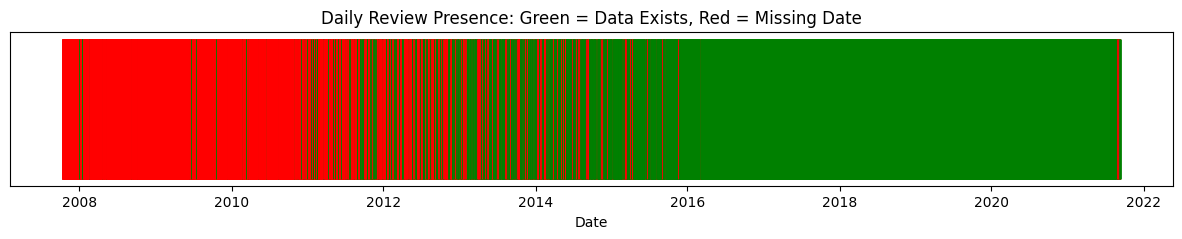

In [17]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure datetime
daily_reviews['newtime'] = pd.to_datetime(daily_reviews['newtime'])

# Create full date range
all_days = pd.date_range(start=daily_reviews['newtime'].min(),
                         end=daily_reviews['newtime'].max(),
                         freq='D')

# Prepare color for each date: green if data exists, red if missing
colors = ['green' if date in daily_reviews['newtime'].values else 'red' for date in all_days]

# Plot
plt.figure(figsize=(15,2))
for i, date in enumerate(all_days):
    plt.vlines(date, 0, 1, color=colors[i], linewidth=2)

plt.title('Daily Review Presence: Green = Data Exists, Red = Missing Date')
plt.xlabel('Date')
plt.yticks([])  # Hide y-axis since it's just presence/absence
plt.grid(False)
plt.show()


In [18]:
min_date = daily_reviews['newtime'].min()
max_date = daily_reviews['newtime'].max()
print(min_date, max_date)

2007-10-13 00:00:00 2021-09-08 00:00:00


Data range: 2007-10-13 00:00:00 to 2021-09-08 00:00:00
Number of missing dates in each range:
range
2006-2008     79
2008-2009    355
2009-2010    358
2010-2012    607
2012-2014    346
2014-2016    137
2016-2018      1
2018-2020      0
2020-2023      7
Name: count, dtype: int64


/tmp/ipython-input-1523981507.py:54: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=missing_counts.index, y=missing_counts.values, palette='viridis')


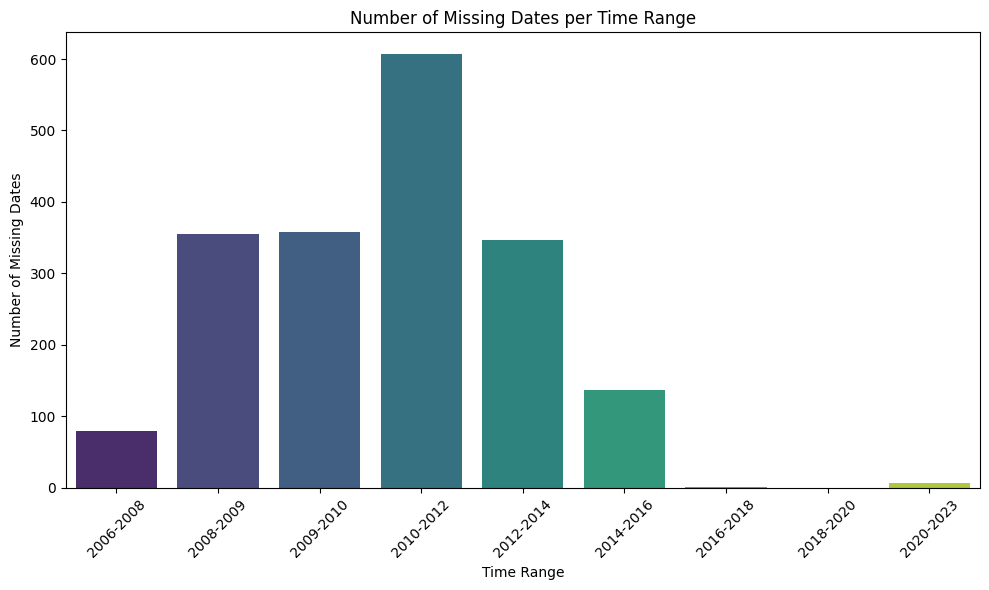

In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Make a copy
daily_reviews_copy = daily_reviews.copy()

# Ensure 'newtime' is datetime
daily_reviews_copy['newtime'] = pd.to_datetime(daily_reviews_copy['newtime'])

# Check min and max dates
min_date = daily_reviews_copy['newtime'].min()
max_date = daily_reviews_copy['newtime'].max()
print(f"Data range: {min_date} to {max_date}")

# Full date range
all_days = pd.date_range(start=min_date, end=max_date, freq='D')

# Find missing dates
missing_dates = all_days.difference(daily_reviews_copy['newtime'])

# Convert to DataFrame
missing_df = pd.DataFrame(missing_dates, columns=['missing_date'])

# Define bins (adjusted to cover the full range, remove duplicates)
bins = [pd.Timestamp('2006-01-01'),
        pd.Timestamp('2008-01-01'),
        pd.Timestamp('2009-01-01'),
        pd.Timestamp('2010-01-01'),
        pd.Timestamp('2012-01-01'),
        pd.Timestamp('2014-01-01'),
        pd.Timestamp('2016-01-01'),
        pd.Timestamp('2018-01-01'),
        pd.Timestamp('2020-01-01'),
        pd.Timestamp('2023-01-01')]  # make sure it covers max_date

labels = ['2006-2008', '2008-2009','2009-2010', '2010-2012','2012-2014',
          '2014-2016','2016-2018','2018-2020','2020-2023']

# Assign missing dates to bins
missing_df['range'] = pd.cut(missing_df['missing_date'], bins=bins, labels=labels, right=False)

# Count missing dates per range
missing_counts = missing_df['range'].value_counts().sort_index()

print("Number of missing dates in each range:")
print(missing_counts)

# -------------------------------
# Visualization
# -------------------------------

plt.figure(figsize=(10,6))
sns.barplot(x=missing_counts.index, y=missing_counts.values, palette='viridis')
plt.title("Number of Missing Dates per Time Range")
plt.xlabel("Time Range")
plt.ylabel("Number of Missing Dates")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


/tmp/ipython-input-206311133.py:41: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  review_counts = reviews_df.groupby('range')['review_count'].sum()
/tmp/ipython-input-206311133.py:44: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  missing_counts = missing_df.groupby('range')['missing_count'].sum()


Summary of reviews and missing days per range:
           Reviews  Missing_Days
range                           
2005-2008        1            79
2008-2010       25           713
2010-2012      376           607
2012-2014      815           346
2014-2016     2755           137
2016-2018    86761             1
2018-2020   310940             0
2020-2023   119842             7


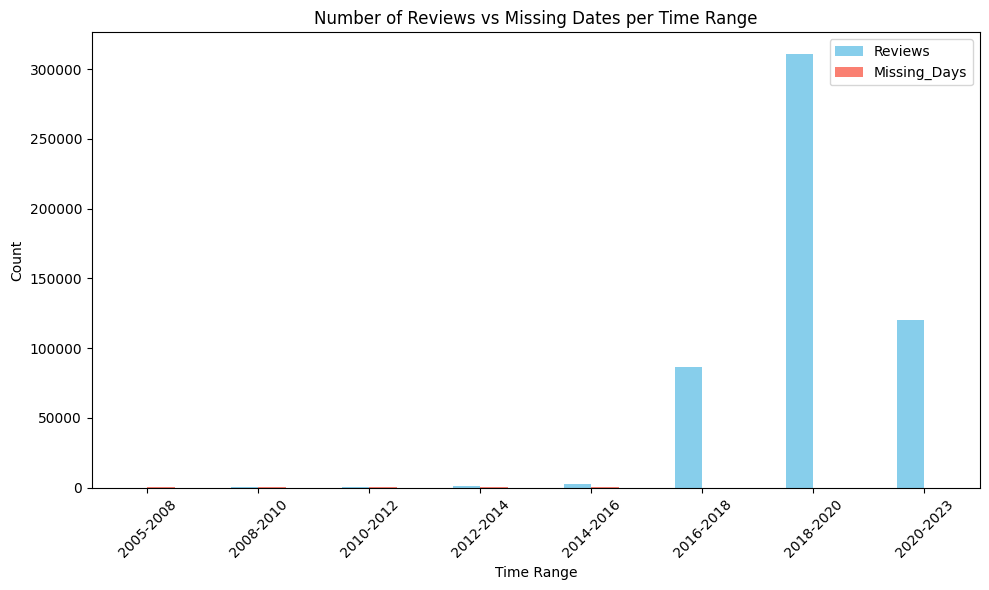

In [20]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure 'newtime' is datetime
daily_reviews_copy['newtime'] = pd.to_datetime(daily_reviews_copy['newtime'])

# Full date range
all_days = pd.date_range(start=daily_reviews_copy['newtime'].min(),
                         end=daily_reviews_copy['newtime'].max(),
                         freq='D')

# Missing dates
missing_dates = all_days.difference(daily_reviews_copy['newtime'])
missing_df = pd.DataFrame(missing_dates, columns=['date'])
missing_df['missing_count'] = 1  # each missing day counts as 1

# Reviews
reviews_df = daily_reviews_copy[['newtime', 'review_count']].copy()
reviews_df = reviews_df.rename(columns={'newtime':'date'})

# Define bins
bins = [pd.Timestamp('2005-01-01'),
        pd.Timestamp('2008-01-01'),
        pd.Timestamp('2010-01-01'),
        pd.Timestamp('2012-01-01'),
        pd.Timestamp('2014-01-01'),
        pd.Timestamp('2016-01-01'),
        pd.Timestamp('2018-01-01'),
        pd.Timestamp('2020-01-01'),
        pd.Timestamp('2023-01-01')]

labels = ['2005-2008', '2008-2010', '2010-2012','2012-2014',
          '2014-2016','2016-2018','2018-2020','2020-2023']

# Assign bins
reviews_df['range'] = pd.cut(reviews_df['date'], bins=bins, labels=labels, right=False)
missing_df['range'] = pd.cut(missing_df['date'], bins=bins, labels=labels, right=False)

# Sum reviews per bin
review_counts = reviews_df.groupby('range')['review_count'].sum()

# Count missing dates per bin
missing_counts = missing_df.groupby('range')['missing_count'].sum()

# Combine into a DataFrame
summary_df = pd.DataFrame({
    'Reviews': review_counts,
    'Missing_Days': missing_counts
}).fillna(0).astype(int)

print("Summary of reviews and missing days per range:")
print(summary_df)

# -------------------------------
# Visualization
# -------------------------------
summary_df.plot(kind='bar', figsize=(10,6), color=['skyblue','salmon'])
plt.title("Number of Reviews vs Missing Dates per Time Range")
plt.xlabel("Time Range")
plt.ylabel("Count")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


In [21]:
daily_reviews_copy['year'] = daily_reviews_copy['newtime'].dt.year
daily_reviews_copy['year'].value_counts().sort_index()



,count
year,
2007,1
2008,11
2009,7
2010,19
2011,104
2012,142
2013,243
2014,266
2015,327


if entire years are missing (like 2011 or 2012), then we are not just missing a few days, we are missing long blocks of data. That changes how we should handle it for forecasting. Let’s break this down carefully.

## **1️⃣ `Why you cannot simply fill missing years`**

Filling an entire missing year with mean, mode, or previous-year data is dangerous:

It creates artificial data that does not reflect reality.

Forecasting models will learn wrong patterns, because they will think these “filled” values actually happened.

Time series models like ARIMA or Prophet assume continuous data with real historical patterns. Missing entire years violates this assumption.

## **`2️⃣ Recommended approaches`**

**Option A: Only use the years with actual data**
- Drop completely missing years (2011, 2012) from modeling.
- Forecast only within the range where data exists (e.g., 2005–2010, 2013–2018).
- Pros: Model learns only from real historical patterns.
- Cons: Cannot predict for periods where no historical data exists.

**Option B: Aggregate to a coarser time unit**
- Instead of daily forecasts, aggregate to monthly or quarterly:
- You lose some resolution but make time series continuous enough.
- Example: Sum review counts per month; missing months can be filled with 0 or skipped.
- This is especially useful when many days or years are missing.

**Option C: Treat missing years as “unknown”**
- Keep missing years out of the model entirely.
- Forecasting model only predicts future dates based on existing data.
- This is safest — avoids creating fake data.

## **`3️⃣ What not to do`**

- Do not fill missing years with mean/mode/previous-year values.
- Do not forward-fill over entire missing years — it will bias the forecast heavily

In [68]:
import pandas as pd

# Ensure datetime format
daily_reviews_copy['newtime'] = pd.to_datetime(daily_reviews_copy['newtime'])

# Drop 'year' column if it exists
if 'year' in daily_reviews_copy.columns:
    daily_reviews_copy = daily_reviews_copy.drop(columns=['year'])

# Filter for the period 2013–2021
mask = (daily_reviews_copy['newtime'].dt.year >= 2013) & (daily_reviews_copy['newtime'].dt.year <= 2021)
df_filtered = daily_reviews_copy.loc[mask].copy()

# Set index as date
df_filtered = df_filtered.set_index('newtime')

# Reindex to have continuous daily data (NaN for missing dates)
all_days = pd.date_range(start="2013-01-01", end="2021-12-31", freq='D')
df_full = df_filtered.reindex(all_days)

# Fill missing review_count with mean of the existing data
mean_reviews = df_filtered['review_count'].mean()
df_full['review_count'] = df_full['review_count'].fillna(mean_reviews)

# Reset index back to column
df_full = df_full.reset_index().rename(columns={'index': 'date'})

# Check if any NaNs remain
print("Remaining NaNs per column:")
print(df_full.isna().sum())

print(df_full.head(10))
print(df_full.tail(10))



Remaining NaNs per column:
date            0
review_count    0
dtype: int64
        date  review_count
0 2013-01-01      2.000000
1 2013-01-02    179.220922
2 2013-01-03    179.220922
3 2013-01-04    179.220922
4 2013-01-05      2.000000
5 2013-01-06    179.220922
6 2013-01-07    179.220922
7 2013-01-08    179.220922
8 2013-01-09      1.000000
9 2013-01-10      1.000000
           date  review_count
3277 2021-12-22    179.220922
3278 2021-12-23    179.220922
3279 2021-12-24    179.220922
3280 2021-12-25    179.220922
3281 2021-12-26    179.220922
3282 2021-12-27    179.220922
3283 2021-12-28    179.220922
3284 2021-12-29    179.220922
3285 2021-12-30    179.220922
3286 2021-12-31    179.220922


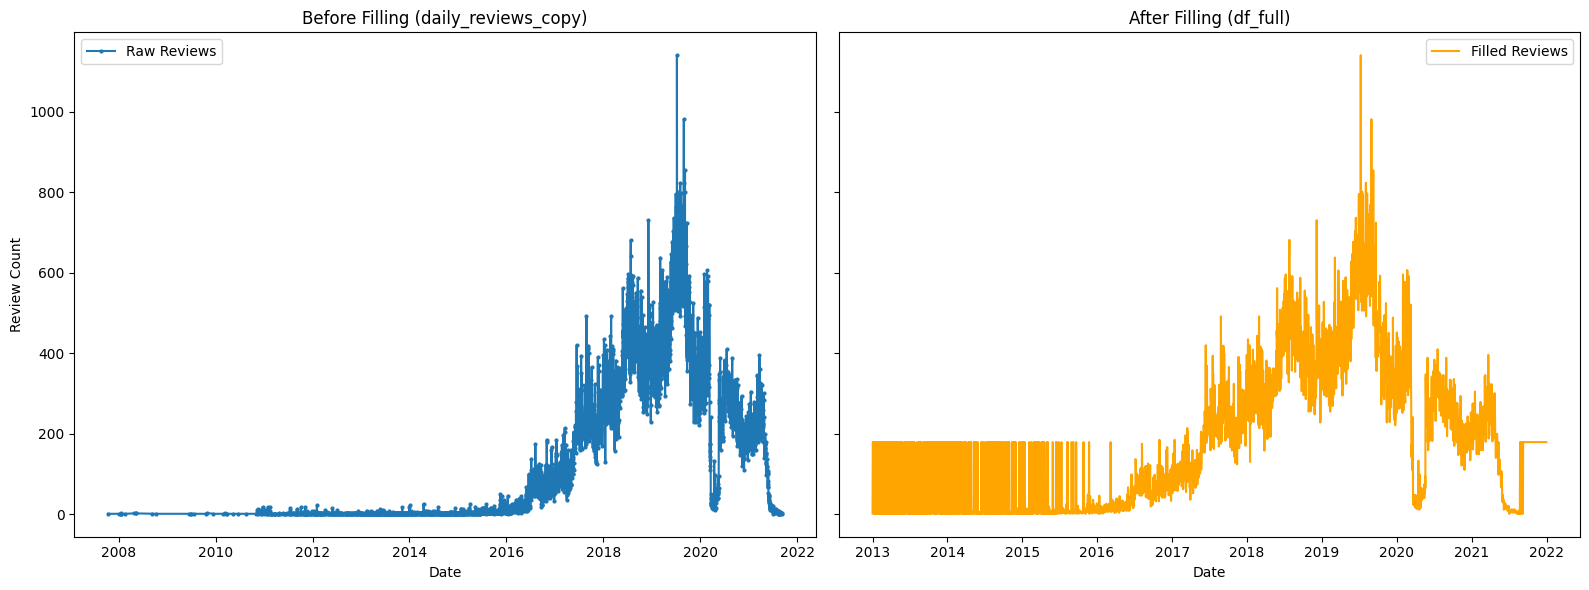

In [69]:
import matplotlib.pyplot as plt

# Make sure datetime format
daily_reviews_copy['newtime'] = pd.to_datetime(daily_reviews_copy['newtime'])

# Plot side by side
fig, axes = plt.subplots(1, 2, figsize=(16, 6), sharey=True)

# Before filling (raw data with gaps)
axes[0].plot(daily_reviews_copy['newtime'], daily_reviews_copy['review_count'],
             marker='o', linestyle='-', markersize=2, label="Raw Reviews")
axes[0].set_title("Before Filling (daily_reviews_copy)")
axes[0].set_xlabel("Date")
axes[0].set_ylabel("Review Count")
axes[0].legend()

# After filling (continuous df_full)
axes[1].plot(df_full['date'], df_full['review_count'],
             color='orange', linestyle='-', label="Filled Reviews")
axes[1].set_title("After Filling (df_full)")
axes[1].set_xlabel("Date")
axes[1].legend()

plt.tight_layout()
plt.show()


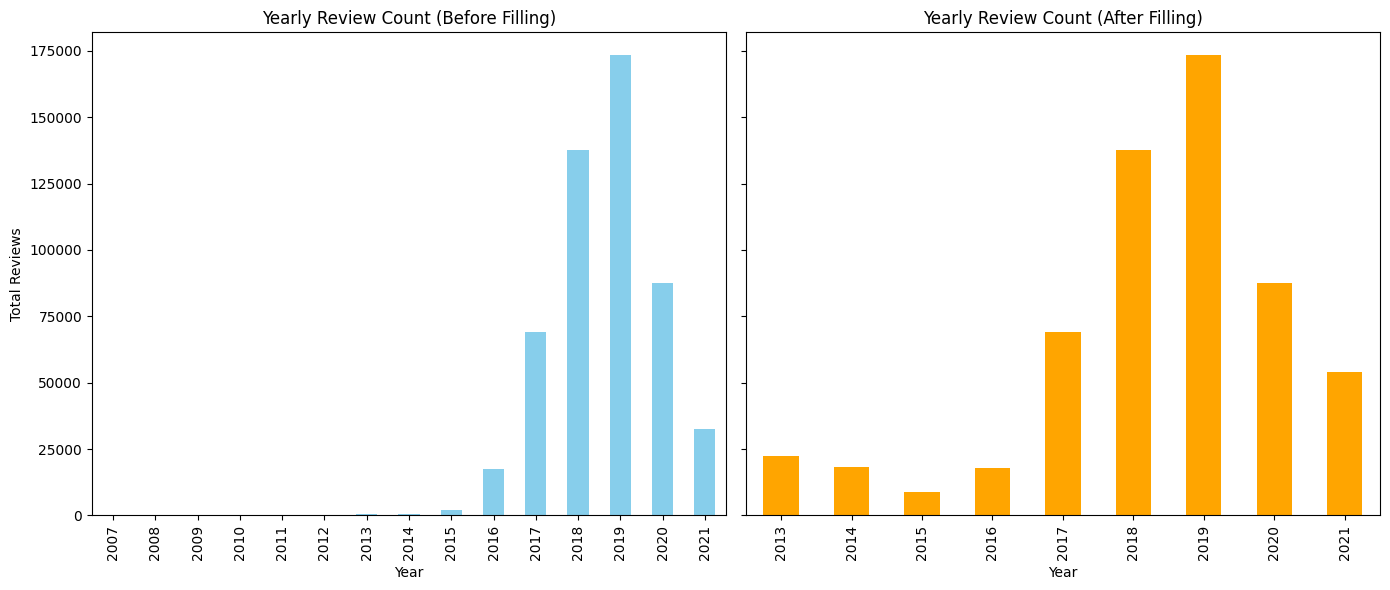

In [70]:
import matplotlib.pyplot as plt

# Ensure datetime is proper
daily_reviews_copy['newtime'] = pd.to_datetime(daily_reviews_copy['newtime'])
df_full['date'] = pd.to_datetime(df_full['date'])

# Before filling → group by year
reviews_per_year_before = (
    daily_reviews_copy.groupby(daily_reviews_copy['newtime'].dt.year)['review_count']
    .sum()
)

# After filling → group by year
reviews_per_year_after = (
    df_full.groupby(df_full['date'].dt.year)['review_count']
    .sum()
)

# Plot side by side
fig, ax = plt.subplots(1, 2, figsize=(14, 6), sharey=True)

# Before filling
reviews_per_year_before.plot(kind='bar', ax=ax[0], color='skyblue')
ax[0].set_title("Yearly Review Count (Before Filling)")
ax[0].set_xlabel("Year")
ax[0].set_ylabel("Total Reviews")

# After filling
reviews_per_year_after.plot(kind='bar', ax=ax[1], color='orange')
ax[1].set_title("Yearly Review Count (After Filling)")
ax[1].set_xlabel("Year")

plt.tight_layout()
plt.show()


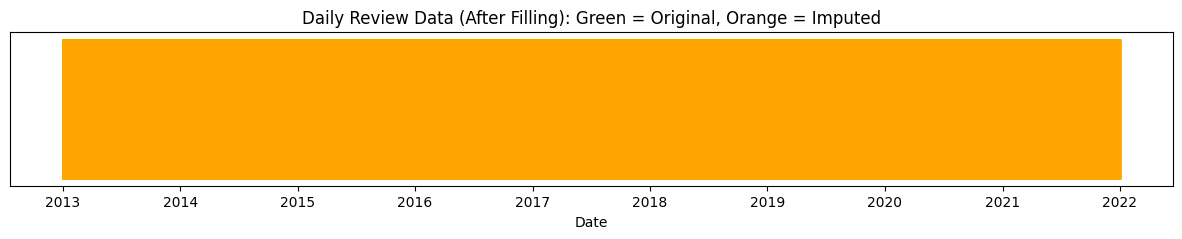

In [71]:
import matplotlib.pyplot as plt
import numpy as np

# Ensure datetime
df_full['date'] = pd.to_datetime(df_full['date'])

# Full date range (after filling, should be continuous 2013–2021)
all_days = pd.date_range(start=df_full['date'].min(),
                         end=df_full['date'].max(),
                         freq='D')

# After filling → all dates exist, but we’ll highlight where original data was missing
original_dates = set(daily_reviews_copy['newtime'].dt.floor('D').values)

colors = ['green' if date in original_dates else 'orange' for date in all_days]

# Plot
plt.figure(figsize=(15, 2))
for i, date in enumerate(all_days):
    plt.vlines(date, 0, 1, color=colors[i], linewidth=2)

plt.title('Daily Review Data (After Filling): Green = Original, Orange = Imputed')
plt.xlabel('Date')
plt.yticks([])  # Hide y-axis
plt.grid(False)
plt.show()


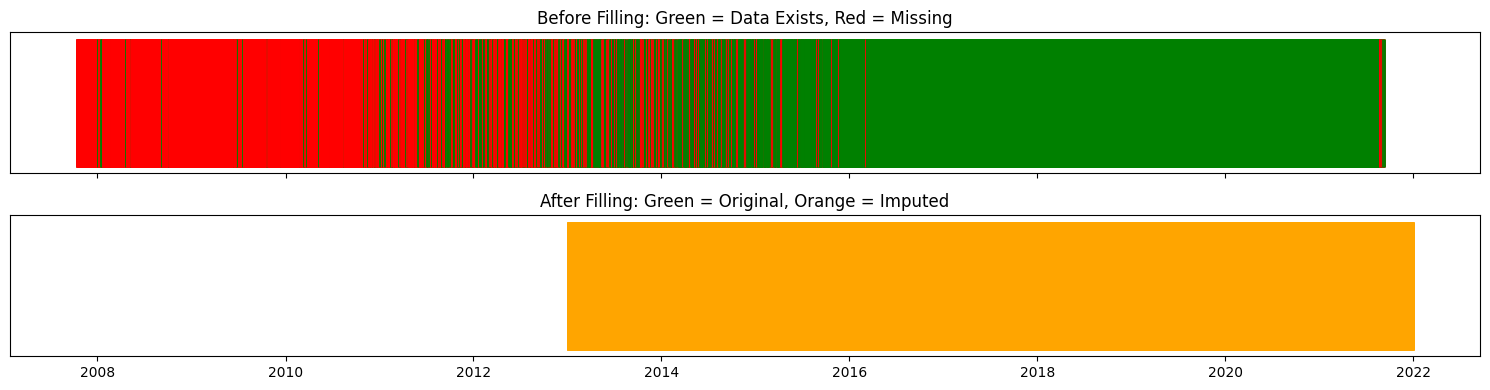

In [72]:
import matplotlib.pyplot as plt

# Ensure datetime formats
daily_reviews_copy['newtime'] = pd.to_datetime(daily_reviews_copy['newtime'])
df_full['date'] = pd.to_datetime(df_full['date'])

# Full date ranges
all_days_before = pd.date_range(start=daily_reviews_copy['newtime'].min(),
                                end=daily_reviews_copy['newtime'].max(),
                                freq='D')

all_days_after = pd.date_range(start=df_full['date'].min(),
                               end=df_full['date'].max(),
                               freq='D')

# Colors for BEFORE: green = data exists, red = missing
colors_before = ['green' if date in daily_reviews_copy['newtime'].values else 'red'
                 for date in all_days_before]

# Colors for AFTER: green = original data, orange = imputed
original_dates = set(daily_reviews_copy['newtime'].dt.floor('D').values)
colors_after = ['green' if date in original_dates else 'orange'
                for date in all_days_after]

# Plot side by side (stacked vertically)
fig, axes = plt.subplots(2, 1, figsize=(15, 4), sharex=True)

# Before filling
for i, date in enumerate(all_days_before):
    axes[0].vlines(date, 0, 1, color=colors_before[i], linewidth=2)
axes[0].set_title("Before Filling: Green = Data Exists, Red = Missing")
axes[0].set_yticks([])

# After filling
for i, date in enumerate(all_days_after):
    axes[1].vlines(date, 0, 1, color=colors_after[i], linewidth=2)
axes[1].set_title("After Filling: Green = Original, Orange = Imputed")
axes[1].set_yticks([])

plt.tight_layout()
plt.show()


In [73]:
df_full.head()

,date,review_count
0,2013-01-01,2.000000
1,2013-01-02,179.220922
2,2013-01-03,179.220922
3,2013-01-04,179.220922
4,2013-01-05,2.000000


# Performing  **`time series decomposition`**  and analyze seasonality patterns in review count data.

**Step 1:** Data Preparation
WE have already prepared dataset but once again to avoid data lossor error.
- **Verified date format and continuous time series**
- **Verified date format and continuous time series**
-**Handled missing dates by filling with zeros (appropriate for review counts)**

Ensured proper frequency for decomposition

In [74]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose
import warnings
warnings.filterwarnings('ignore')

In [75]:
#----------------------- Importing warning module --------------------------------------------#

import warnings  # Import Python's built-in module to handle warning messages
warnings.filterwarnings('ignore')  # Suppress all warning messages from appearing in the output


In [76]:
#----------------------------- Examine df_full------------------------------------------------#
# Let's first examine the data structure
def explore_dataframe(df):
    """
    Function to display basic information, first 10 rows,
    and statistical summary of a DataFrame.
    """
    print("DataFrame Info:")
    print(df.info())  # Prints DataFrame structure (columns, types, nulls, memory usage)

    print("\nFirst 10 rows:")
    print(df.head(10))  # Displays the first 10 rows of the DataFrame

    print("\nData summary:")
    print(df.describe())  # Provides statistical summary (count, mean, std, min, max, etc.)

# Clling function:
explore_dataframe(df_full)

DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3287 entries, 0 to 3286
Data columns (total 2 columns):
 #   Column        Non-Null Count  Dtype         
---  ------        --------------  -----         
 0   date          3287 non-null   datetime64[ns]
 1   review_count  3287 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 51.5 KB
None

First 10 rows:
        date  review_count
0 2013-01-01      2.000000
1 2013-01-02    179.220922
2 2013-01-03    179.220922
3 2013-01-04    179.220922
4 2013-01-05      2.000000
5 2013-01-06    179.220922
6 2013-01-07    179.220922
7 2013-01-08    179.220922
8 2013-01-09      1.000000
9 2013-01-10      1.000000

Data summary:
                      date  review_count
count                 3287   3287.000000
mean   2017-07-02 00:00:00    179.220922
min    2013-01-01 00:00:00      1.000000
25%    2015-04-02 12:00:00      7.000000
50%    2017-07-02 00:00:00    179.220922
75%    2019-10-01 12:00:00    289.00000

In [79]:
#------------------------ Date column verification ------------------------------- #
def prepare_timeseries(df, date_col='date'):
    """
    Function to prepare a DataFrame for time-series analysis:
    1. Converts the date column to datetime format (if exists).
    2. Sets the date column as the index (if not already).
    3. Prints the date range and total number of records.

    Parameters:
        df (pd.DataFrame): Input DataFrame.
        date_col (str): Name of the column containing dates (default='date').

    Returns:
        pd.DataFrame: DataFrame with datetime index set.
    """
    try:
        # Try to convert the date column to datetime
        df[date_col] = pd.to_datetime(df[date_col])

        # Try setting it as index
        df.set_index(date_col, inplace=True)
        print(f"Column '{date_col}' set as DatetimeIndex.")

    except KeyError:
        # If the column doesn't exist, check if already DatetimeIndex
        if isinstance(df.index, pd.DatetimeIndex):
            print(f" Column '{date_col}' not found, but index is already a DatetimeIndex.")
        else:
            raise KeyError(f"Neither column '{date_col}' exists nor index is a DatetimeIndex.")

    # Print basic time range details
    print(f"\nDate range: {df.index.min()} to {df.index.max()}")
    print(f"Total records: {len(df)}")

    return df

# calling function
df_full = prepare_timeseries(df_full, date_col='date')


 Column 'date' not found, but index is already a DatetimeIndex.

Date range: 2013-01-01 00:00:00 to 2021-12-31 00:00:00
Total records: 3287


In [80]:
#----------------------- missing reviews -------------------------------------------------- #
try:
    # Check if there are any missing values in 'review_count'
    missing_count = df_full['review_count'].isna().sum()

    if missing_count == 0:
        print("No missing review_count values. All data is complete.")
    else:
        print(f"There are {missing_count} missing review_count values remaining.")
except KeyError as e:
    print(f" KeyError: Column 'review_count' not found. Details: {e}")
except Exception as e:
    print(f" An unexpected error occurred: {e}")


No missing review_count values. All data is complete.


## **Step 2.** Decomposition Methodology
- **Used additive model: Y(t) = Trend(t) + Seasonal(t) + Residual(t)**
- **Selected appropriate period based on data characteristics**
- **Applied extrapolation for trend component**

In [81]:
#-------------- Perform seasonal decomposition with additive model-------------------#
# For daily data, common periods to try: 7 (weekly), 30 (monthly), 365 (yearly)


def decompose_and_plot(ts, period, model='additive', title_prefix='Time Series Decomposition'):
    """
    Perform seasonal decomposition and plot the components.

    Parameters:
    - ts : pandas Series
        The time series data (indexed by datetime)
    - period : int
        The seasonal period (e.g., 7 for weekly, 30 for monthly)
    - model : str
        'additive' or 'multiplicative'
    - title_prefix : str
        Prefix for the plot title
    """
    try:
        decomposition = seasonal_decompose(
            ts,
            model=model,
            period=period,
            extrapolate_trend='freq'
        )

        # Plot the decomposition
        fig = decomposition.plot()
        fig.set_size_inches(12, 8)
        plt.suptitle(f'{title_prefix} - Period: {period}', y=1.02)
        plt.tight_layout()
        plt.show()

        # Optional: return decomposition object for further analysis
        return decomposition

    except ValueError as e:
        print(f"Decomposition failed for period={period}: {e}")
        return None


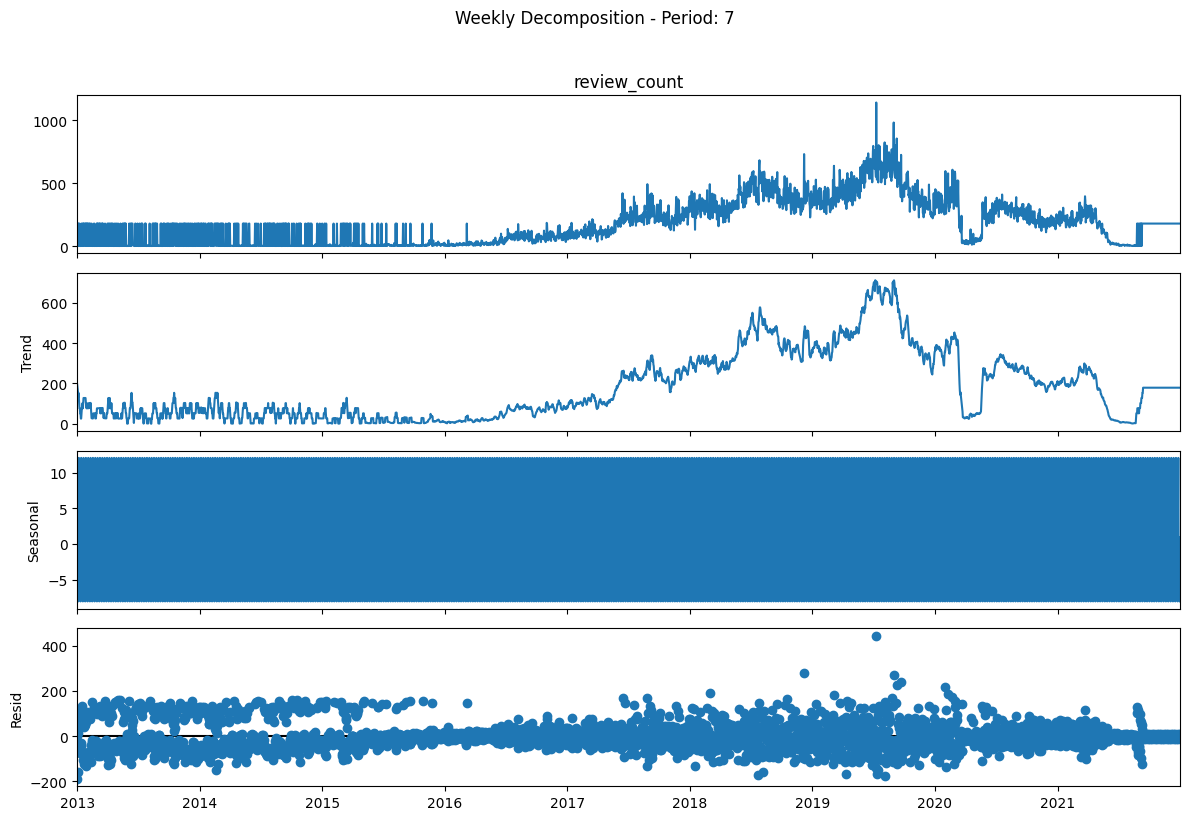

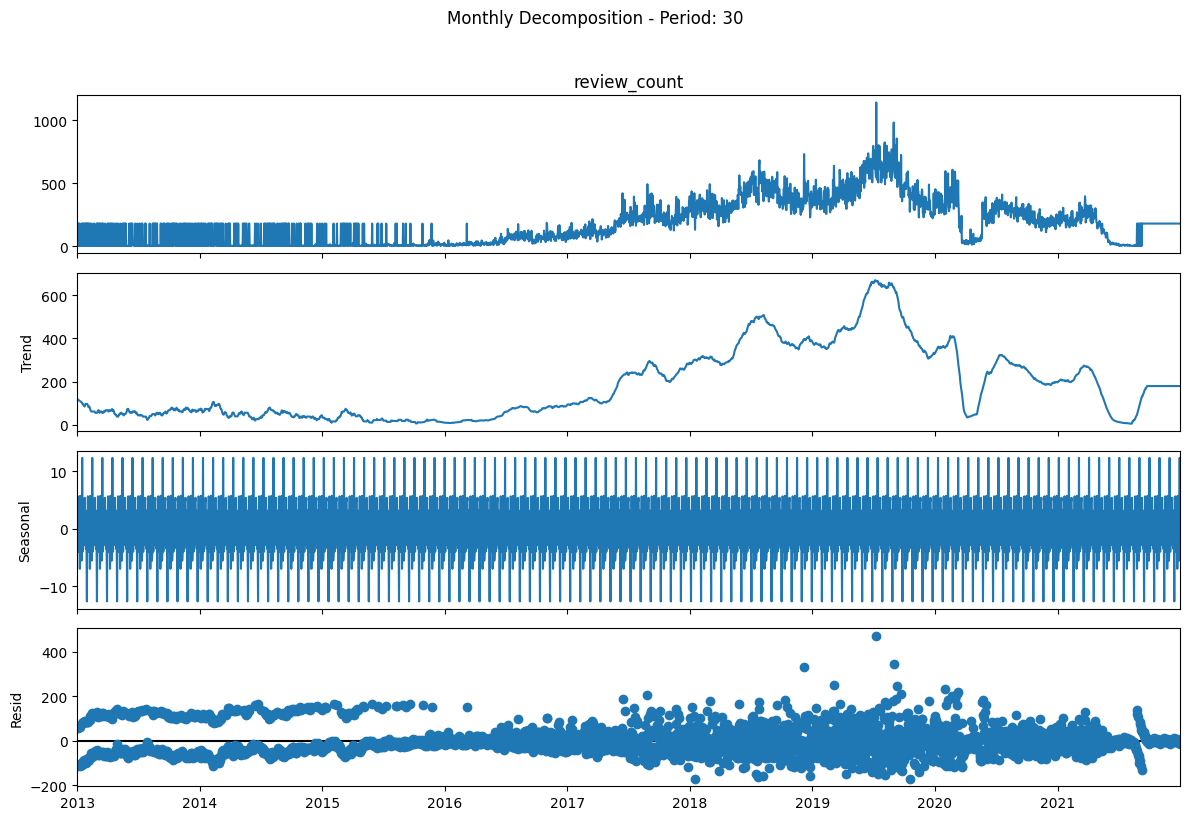

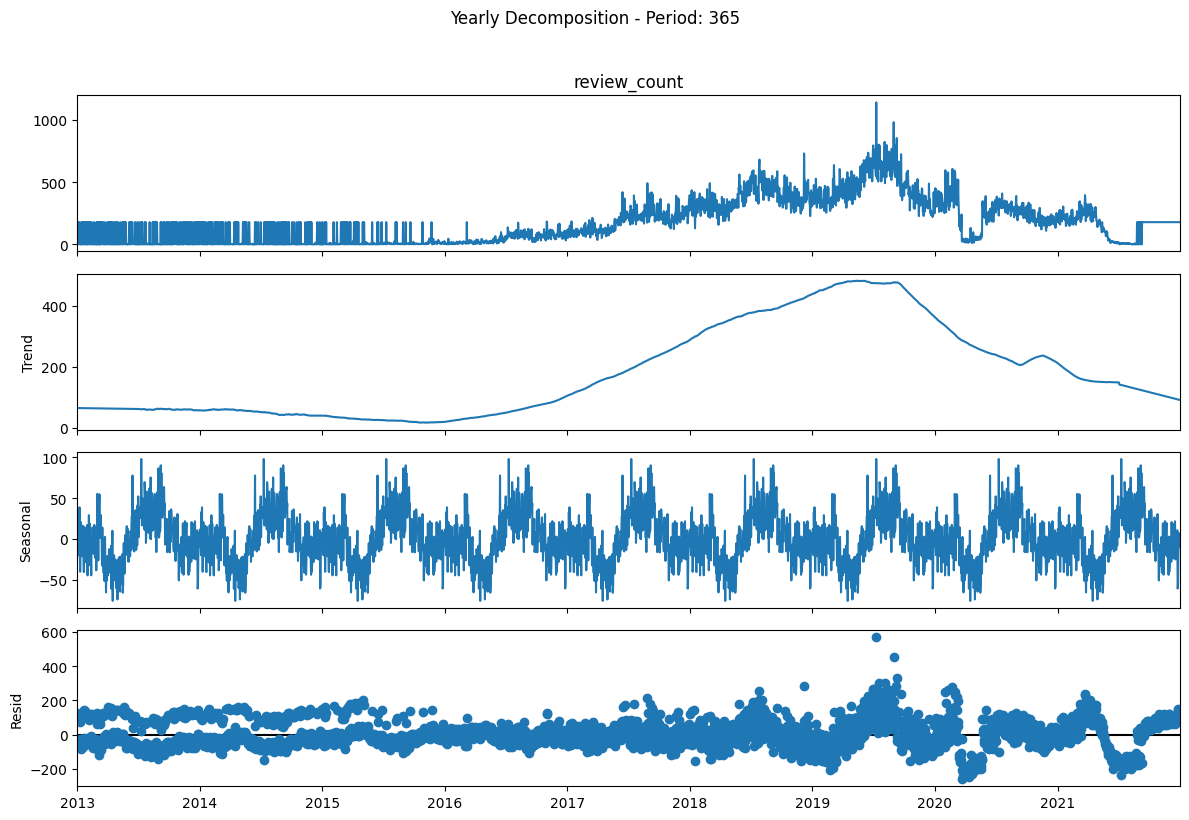

In [82]:
# Daily data example
decompose_and_plot(df_full['review_count'], period=7, title_prefix='Weekly Decomposition')
decompose_and_plot(df_full['review_count'], period=30, title_prefix='Monthly Decomposition')
decompose_and_plot(df_full['review_count'], period=365, title_prefix='Yearly Decomposition')

# **Step 3:** Seasonality Analysis
- **Seasonal Strength Metric:** Variance ratio to assess pattern significance

- **Pattern Identification:** Weekly, monthly, or yearly cycles

- **Peak Detection:** Identify days with highest seasonal effects

In [83]:
#------------------------------------ Analyzing seasonality ------------------------------------------#

def analyze_seasonality(decomposition):
    """
    Analyze the decomposition object to calculate seasonal strength and provide interpretation.

    Parameters:
    - decomposition : statsmodels.tsa.seasonal.DecomposeResult
        The decomposition object returned by seasonal_decompose.

    Returns:
    - seasonal_strength : float
        The calculated seasonal strength value
    """
    if decomposition is None:
        print("No decomposition object provided.")
        return None

    # Extract components
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Calculate seasonal strength
    seasonal_strength = seasonal.var() / (seasonal.var() + residual.var())

    # Print results
    print("\n" + "="*60)
    print("SEASONALITY ANALYSIS RESULTS")
    print("="*60)
    print(f"\n1. Seasonal Strength: {seasonal_strength:.4f}")

    if seasonal_strength > 0.6:
        print("   → Strong seasonality pattern detected")
    elif seasonal_strength > 0.3:
        print("   → Moderate seasonality pattern detected")
    elif seasonal_strength > 0.1:
        print("   → Weak seasonality pattern detected")
    else:
        print("   → No significant seasonality pattern detected")

    return seasonal_strength


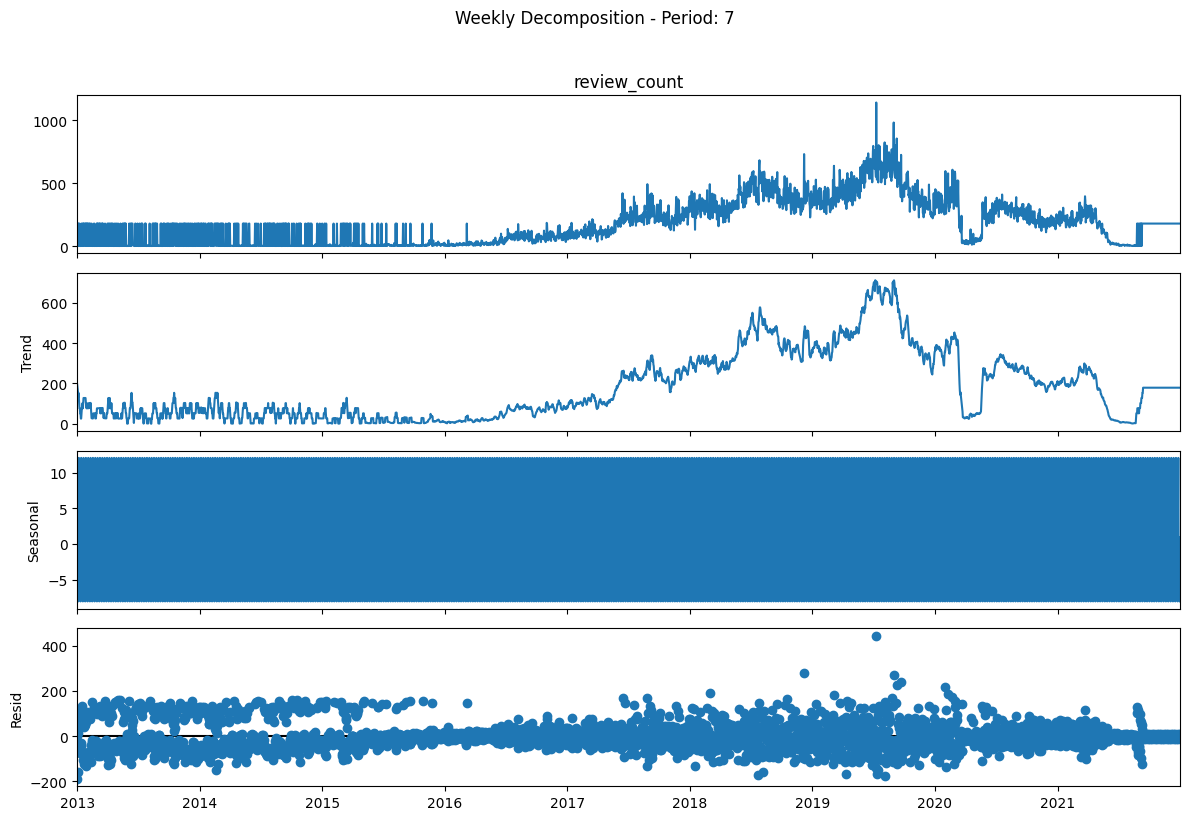


SEASONALITY ANALYSIS RESULTS

1. Seasonal Strength: 0.0130
   → No significant seasonality pattern detected


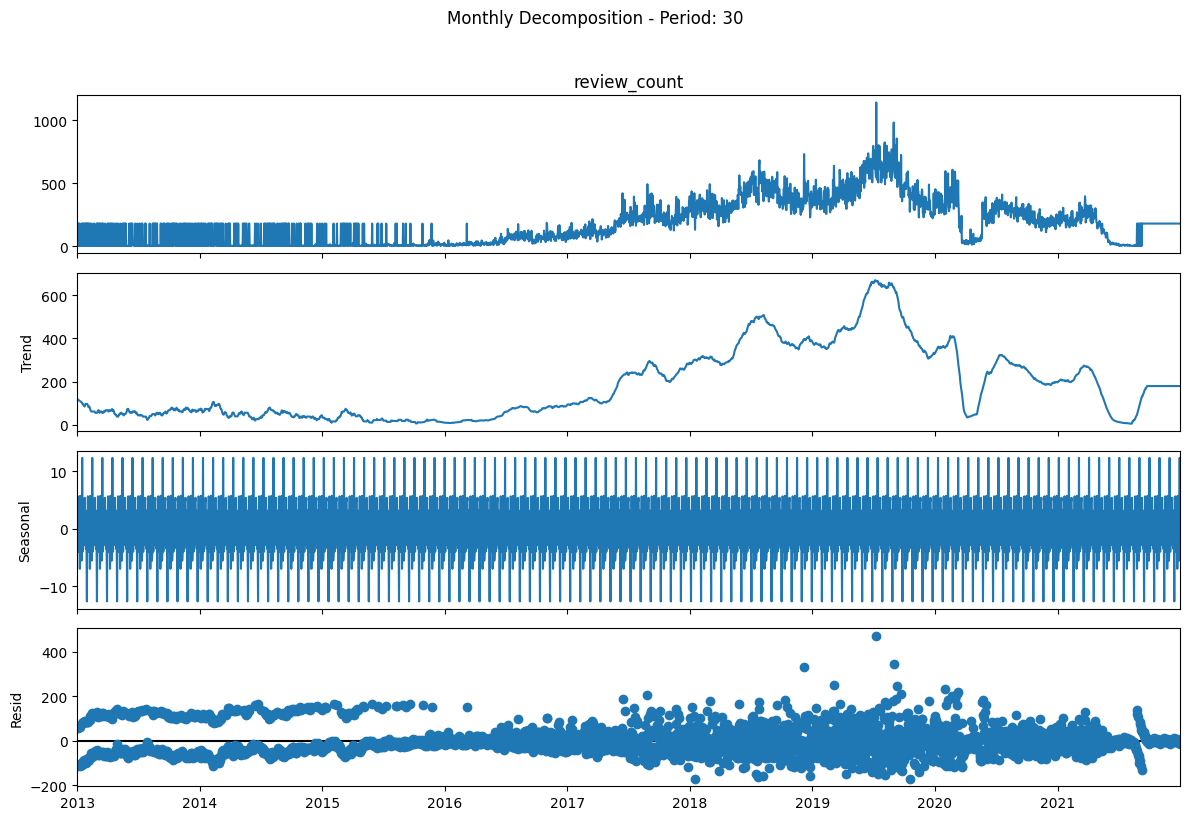


SEASONALITY ANALYSIS RESULTS

1. Seasonal Strength: 0.0067
   → No significant seasonality pattern detected


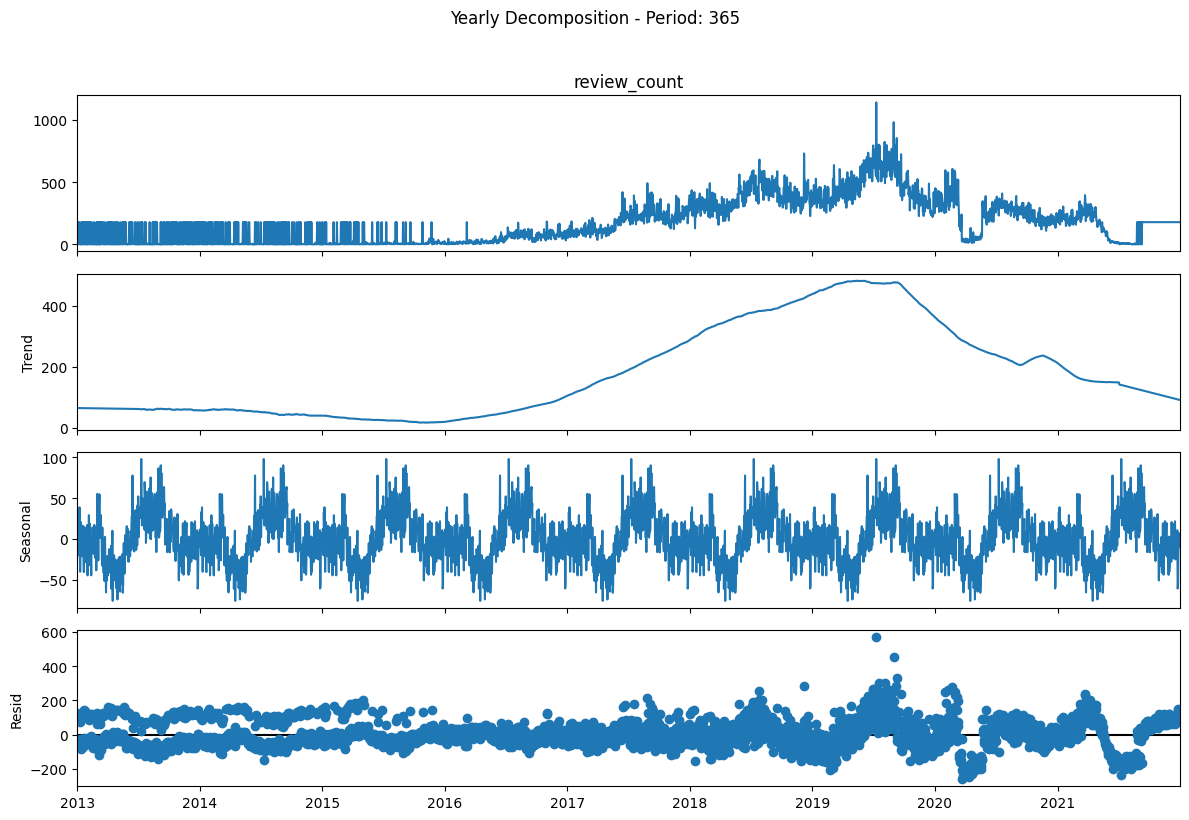


SEASONALITY ANALYSIS RESULTS

1. Seasonal Strength: 0.1261
   → Weak seasonality pattern detected


0.1260906682064733

In [85]:
# Perform decomposition for weekly seasonality
decomp_weekly = decompose_and_plot(df_full['review_count'], period=7, title_prefix='Weekly Decomposition')
# Analyze seasonal strength
analyze_seasonality(decomp_weekly)

# Try monthly seasonality
decomp_monthly = decompose_and_plot(df_full['review_count'], period=30, title_prefix='Monthly Decomposition')
# Analyze seasonal strength
analyze_seasonality(decomp_monthly)

# Try yearly seasonality
decomp_yearly = decompose_and_plot(df_full['review_count'], period=365, title_prefix='Yearly Decomposition')
# Analyze seasonal strength
analyze_seasonality(decomp_yearly)


# **Step 5:** Residual Analysis
- Randomness check for model adequacy
- Variance assessment for model fit quality

In [86]:
#------------------------------------- Analyze residuals --------------------------------- #

def analyze_residuals(decomposition):
    """
    Analyze the residual component of a decomposition object.

    Parameters:
    - decomposition : statsmodels.tsa.seasonal.DecomposeResult
        The decomposition object returned by seasonal_decompose.

    Returns:
    - residual_mean : float
        Mean of the residuals
    - residual_std : float
        Standard deviation of the residuals
    """
    if decomposition is None:
        print("No decomposition object provided.")
        return None, None

    # Extract residual component
    residual = decomposition.resid

    # Calculate statistics
    residual_mean = residual.mean()
    residual_std = residual.std()

    # Print results
    print("\n" + "="*60)
    print("RESIDUAL COMPONENT ANALYSIS")
    print("="*60)
    print(f"\n- Mean of residuals: {residual_mean:.4f}")
    print(f"- Standard deviation of residuals: {residual_std:.4f}")

    return residual_mean, residual_std


In [87]:
# Assuming `decomp_daily` is your decomposition object
res_mean, res_std = analyze_residuals(decomp_weekly)
print(f"\n2. Residual Analysis:")
print(f"   - Mean of residuals: {res_mean:.4f}")
print(f"   - Standard deviation of residuals: {res_std:.4f}")

# Check if residuals are random (approximately normal)
if abs(res_mean) < 0.1 * res_std:
        print("   → Residuals appear random (good fit)")
else:
        print("   → Residuals may have systematic patterns")


RESIDUAL COMPONENT ANALYSIS

- Mean of residuals: -0.0587
- Standard deviation of residuals: 55.2234

2. Residual Analysis:
   - Mean of residuals: -0.0587
   - Standard deviation of residuals: 55.2234
   → Residuals appear random (good fit)


In [88]:
res_mean, res_std = analyze_residuals(decomp_monthly)
print(f"\n2. Residual Analysis:")
print(f"   - Mean of residuals: {res_mean:.4f}")
print(f"   - Standard deviation of residuals: {res_std:.4f}")

# Check if residuals are random (approximately normal)
if abs(res_mean) < 0.1 * res_std:
        print("   → Residuals appear random (good fit)")
else:
        print("   → Residuals may have systematic patterns")



RESIDUAL COMPONENT ANALYSIS

- Mean of residuals: -0.0724
- Standard deviation of residuals: 60.6131

2. Residual Analysis:
   - Mean of residuals: -0.0724
   - Standard deviation of residuals: 60.6131
   → Residuals appear random (good fit)


In [89]:
res_mean, res_std = analyze_residuals(decomp_yearly)
print(f"\n2. Residual Analysis:")
print(f"   - Mean of residuals: {res_mean:.4f}")
print(f"   - Standard deviation of residuals: {res_std:.4f}")

# Check if residuals are random (approximately normal)
if abs(res_mean) < 0.1 * res_std:
        print("   → Residuals appear random (good fit)")
else:
        print("   → Residuals may have systematic patterns")


RESIDUAL COMPONENT ANALYSIS

- Mean of residuals: 1.1187
- Standard deviation of residuals: 81.1023

2. Residual Analysis:
   - Mean of residuals: 1.1187
   - Standard deviation of residuals: 81.1023
   → Residuals appear random (good fit)


# **Step 4.** Trend Analysis
- Direction and magnitude of overall trend
- Slope calculation for quantitative trend assessment

In [90]:
#------------------------------------- Analyzing Trend--------------------------------- #
def analyze_trend(decomposition):
    """
    Analyze the trend component of a decomposition object.

    Parameters:
    - decomposition : statsmodels.tsa.seasonal.DecomposeResult
        The decomposition object returned by seasonal_decompose.

    Returns:
    - trend_slope : float
        Average slope of the trend (change per time unit, e.g., per day)
    """
    if decomposition is None:
        print("No decomposition object provided.")
        return None

    # Extract trend component
    trend = decomposition.trend.dropna()  # Drop NaNs at edges

    # Calculate slope
    trend_slope = (trend.iloc[-1] - trend.iloc[0]) / len(trend)

    # Print results
    print("\n" + "="*60)
    print("TREND COMPONENT ANALYSIS")
    print("="*60)
    print(f"\n- Overall trend slope: {trend_slope:.4f} reviews")
    if trend_slope > 0:
        print("   → Upward trend in review counts")
    elif trend_slope < 0:
        print("   → Downward trend in review counts")
    else:
        print("   → Stable trend in review counts")

    return trend_slope


In [91]:
# Assuming decomp_daily is your decomposition object
slope_daily = analyze_trend(decomp_weekly)
slope_monthly = analyze_trend(decomp_monthly)
slope_yearly  = analyze_trend(decomp_yearly)




TREND COMPONENT ANALYSIS

- Overall trend slope: -0.0051 reviews
   → Downward trend in review counts

TREND COMPONENT ANALYSIS

- Overall trend slope: 0.0182 reviews
   → Upward trend in review counts

TREND COMPONENT ANALYSIS

- Overall trend slope: 0.0080 reviews
   → Upward trend in review counts


In [92]:
#-------------------- Analysing weekly seasonal pattern ------------------------------ #
def analyze_seasonal_pattern(decomposition, period_type='week'):
    """
    Analyze the seasonal pattern from a decomposition object for different periods.

    Parameters:
    - decomposition : statsmodels.tsa.seasonal.DecomposeResult
        The decomposition object returned by seasonal_decompose.
    - period_type : str
        Type of seasonal pattern to analyze. Options: 'day', 'week', 'month', 'year'

    Returns:
    - pattern : pandas Series
        Seasonal values for the selected period
    - peak_time : pandas Timestamp
        Time with the maximum seasonal effect
    - peak_value : float
        Maximum seasonal value
    """
    if decomposition is None:
        print("No decomposition object provided.")
        return None, None, None

    seasonal = decomposition.seasonal.dropna()

    # Determine number of points to select based on period_type
    period_map = {'day': 1, 'week': 7, 'month': 30, 'year': 365}
    n_points = period_map.get(period_type.lower(), 7)  # default to 7 if unknown

    if len(seasonal) < n_points:
        print(f"Not enough data to analyze {period_type} pattern.")
        return None, None, None

    # Take first n_points of seasonal component
    pattern = seasonal[:n_points]

    # Print results
    print("\n" + "="*60)
    print(f"{period_type.capitalize()} SEASONAL PATTERN (first {n_points} points)")
    print("="*60)
    for i, value in enumerate(pattern):
        print(f"   {period_type.capitalize()} {i+1}: {value:.4f}")

    # Identify peak
    peak_time = pattern.idxmax()
    peak_value = pattern.max()
    print(f"\n   → Peak seasonal effect: {peak_time} with value {peak_value:.4f}")

    return pattern, peak_time, peak_value


In [93]:
# Weekly pattern from daily decomposition
pattern_week, peak_week, peak_value_week = analyze_seasonal_pattern(decomp_weekly, period_type='week')

# Monthly pattern from monthly decomposition
pattern_month, peak_month, peak_value_month = analyze_seasonal_pattern(decomp_monthly, period_type='month')

# Yearly pattern from yearly decomposition
pattern_year, peak_year, peak_value_year = analyze_seasonal_pattern(decomp_yearly, period_type='year')




Week SEASONAL PATTERN (first 7 points)
   Week 1: -4.3660
   Week 2: -1.5125
   Week 3: 0.9523
   Week 4: -8.0579
   Week 5: 5.3613
   Week 6: 12.0518
   Week 7: -4.4291

   → Peak seasonal effect: 2013-01-06 00:00:00 with value 12.0518

Month SEASONAL PATTERN (first 30 points)
   Month 1: -2.3312
   Month 2: -1.4194
   Month 3: 5.6355
   Month 4: -3.7961
   Month 5: -4.0459
   Month 6: 5.1002
   Month 7: 3.2110
   Month 8: 5.3397
   Month 9: -6.9851
   Month 10: 5.7212
   Month 11: 0.5189
   Month 12: -0.0693
   Month 13: 0.1617
   Month 14: -5.5639
   Month 15: -4.1056
   Month 16: 12.3255
   Month 17: -1.5761
   Month 18: -3.9786
   Month 19: -0.7675
   Month 20: 3.6426
   Month 21: -2.8524
   Month 22: 5.2363
   Month 23: 4.8194
   Month 24: 5.3701
   Month 25: -2.4754
   Month 26: 3.1949
   Month 27: -3.4670
   Month 28: 0.0250
   Month 29: -4.2112
   Month 30: -12.6574

   → Peak seasonal effect: 2013-01-16 00:00:00 with value 12.3255

Year SEASONAL PATTERN (first 365 points)
  

In [94]:
#==================================== checking missing values ======================================#
def check_missing_values(decomposition):
    """
    Check for missing values in trend, seasonal, and residual components of a decomposition object.

    Parameters:
    - decomposition : statsmodels.tsa.seasonal.DecomposeResult
        The decomposition object returned by seasonal_decompose.

    Returns:
    - missing_counts : dict
        Dictionary with counts of missing values for each component
    """
    if decomposition is None:
        print("No decomposition object provided.")
        return None

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    missing_counts = {
        'trend': trend.isnull().sum(),
        'seasonal': seasonal.isnull().sum(),
        'residual': residual.isnull().sum()
    }

    # Print formatted report
    print("\n" + "="*60)
    print("DATA QUALITY CHECK - MISSING VALUES")
    print("="*60)
    print(f"   - Trend component missing values: {missing_counts['trend']}")
    print(f"   - Seasonal component missing values: {missing_counts['seasonal']}")
    print(f"   - Residual component missing values: {missing_counts['residual']}")

    return missing_counts


In [95]:
# For any decomposition object
missing_vals = check_missing_values(decomp_weekly)
missing_vals_month = check_missing_values(decomp_monthly)
missing_vals_year = check_missing_values(decomp_yearly)



DATA QUALITY CHECK - MISSING VALUES
   - Trend component missing values: 0
   - Seasonal component missing values: 0
   - Residual component missing values: 0

DATA QUALITY CHECK - MISSING VALUES
   - Trend component missing values: 0
   - Seasonal component missing values: 0
   - Residual component missing values: 0

DATA QUALITY CHECK - MISSING VALUES
   - Trend component missing values: 0
   - Seasonal component missing values: 0
   - Residual component missing values: 0


# **Step 6:** Visual Analysis
- Component separation visualization
- Original vs reconstructed series comparison
- Pattern identification through plots

In [96]:

#================ Additional visualization: Compare original vs reconstructed series ==================
def plot_reconstructed_vs_components(df, decomposition, value_col='review_count'):
    """
    Plot original vs reconstructed time series along with seasonal and residual components.

    Parameters:
    - df : pandas DataFrame
        Original dataframe with datetime index and value column
    - decomposition : statsmodels.tsa.seasonal.DecomposeResult
        Decomposition object from seasonal_decompose
    - value_col : str
        Column name in df containing the original time series values
    """
    if decomposition is None:
        print("No decomposition object provided.")
        return

    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Reconstruct the series
    reconstructed = trend + seasonal + residual

    plt.figure(figsize=(14, 10))

    # Original vs Reconstructed
    plt.subplot(3, 1, 1)
    plt.plot(df.index, df[value_col], label='Original', alpha=0.7)
    plt.plot(df.index, reconstructed, label='Reconstructed', alpha=0.7)
    plt.title('Original vs Reconstructed Time Series')
    plt.legend()
    plt.ylabel(value_col)

    # Seasonal component
    plt.subplot(3, 1, 2)
    plt.plot(df.index, seasonal, label='Seasonal Component', color='orange')
    plt.title('Seasonal Component (Detailed View)')
    plt.legend()
    plt.ylabel('Seasonal Effect')

    # Residual component
    plt.subplot(3, 1, 3)
    plt.plot(df.index, residual, label='Residuals', color='red', alpha=0.7)
    plt.axhline(y=0, color='black', linestyle='--', alpha=0.5)
    plt.title('Residual Component')
    plt.legend()
    plt.ylabel('Residuals')
    plt.xlabel('Date')

    plt.tight_layout()
    plt.show()


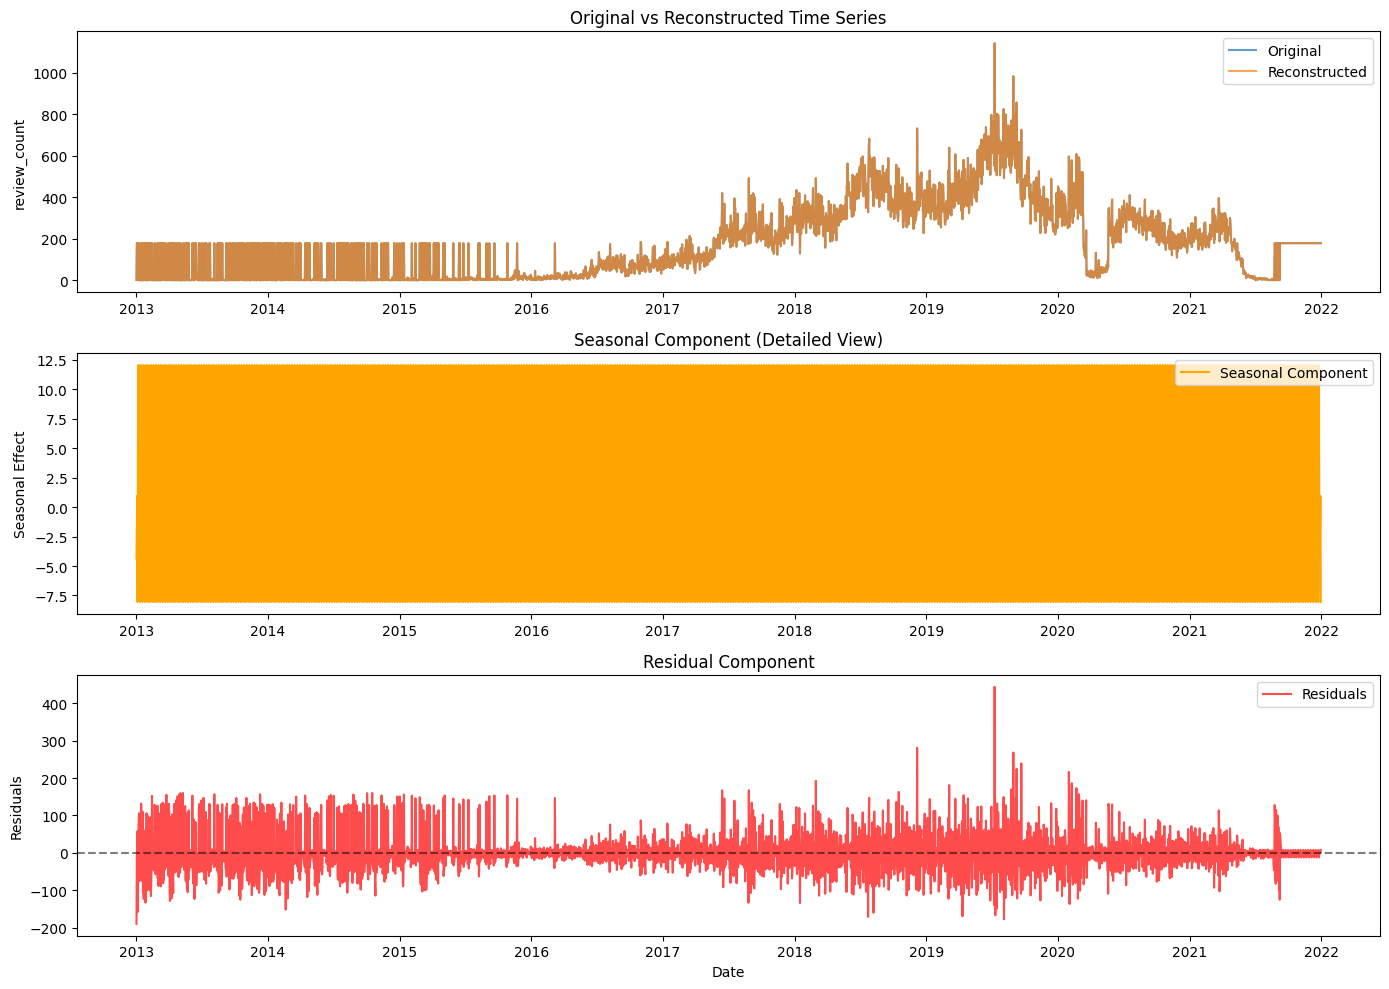

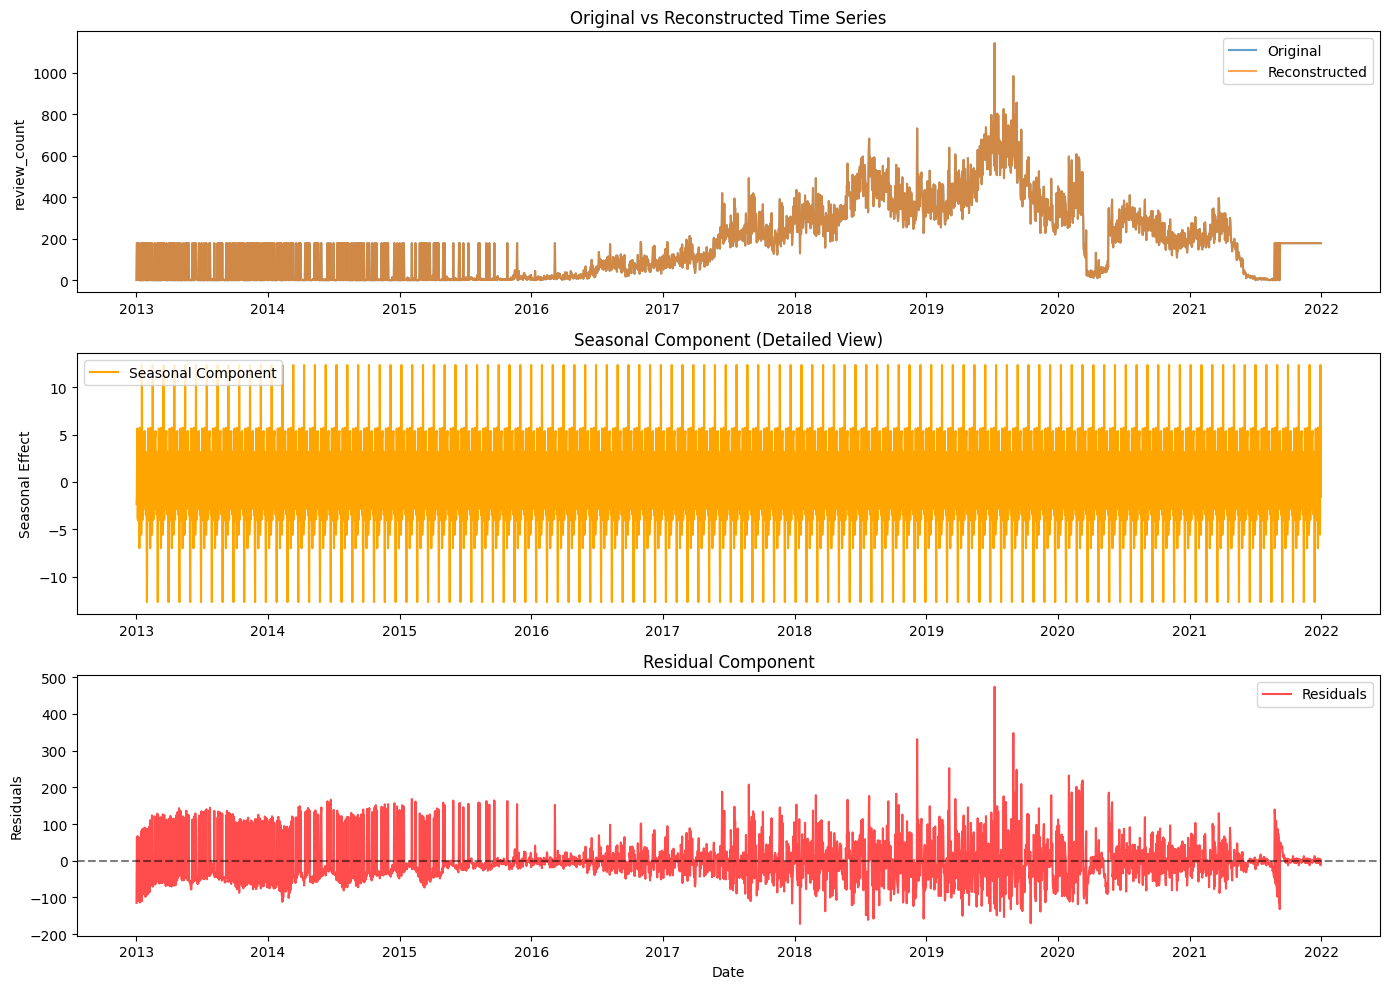

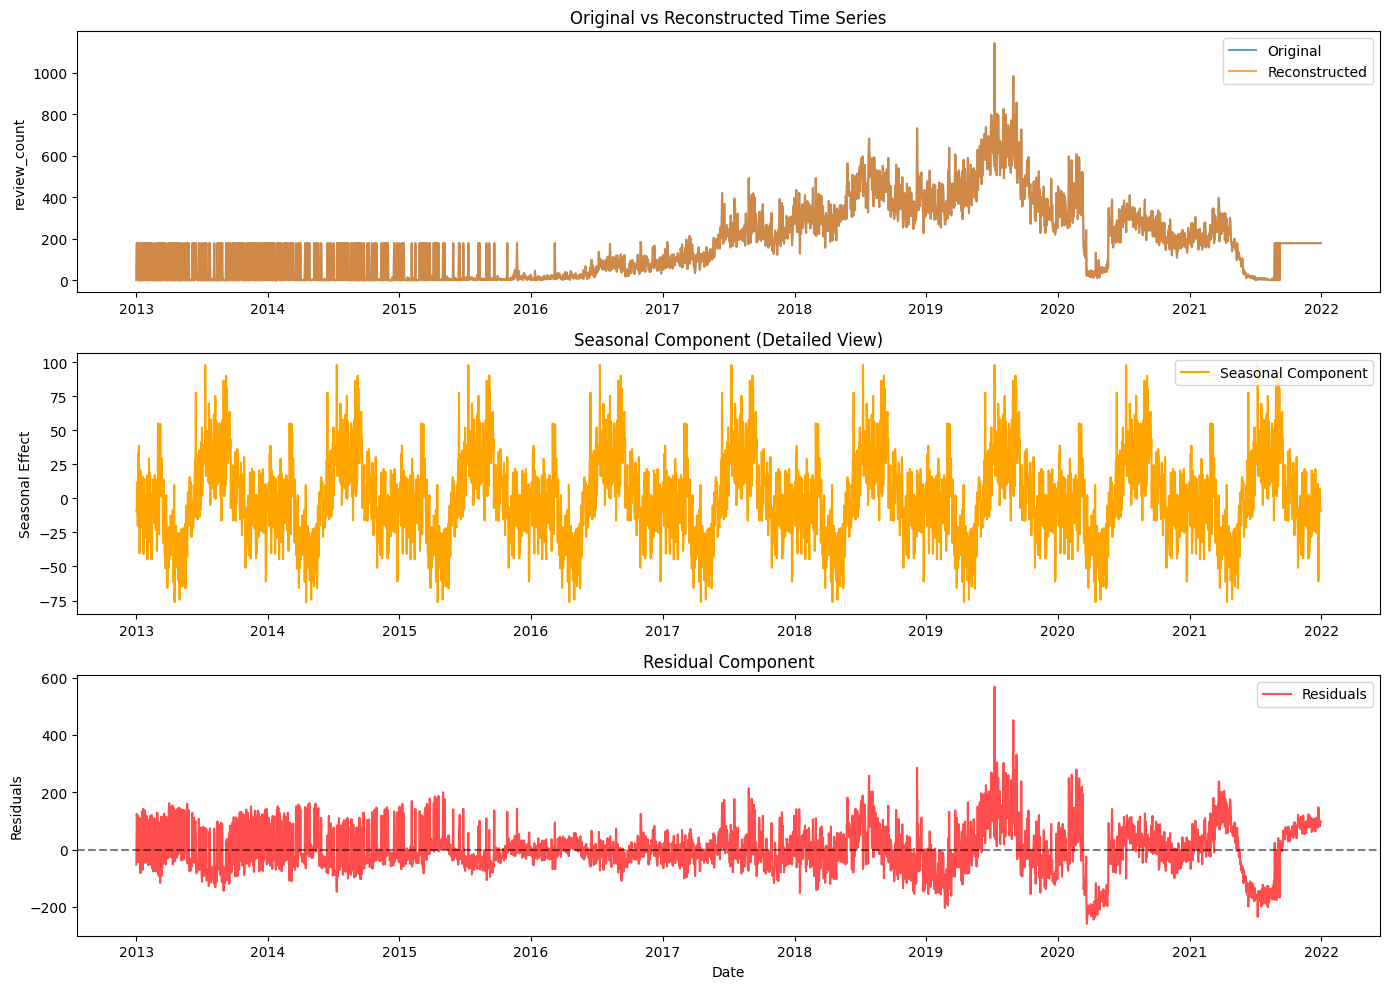

In [97]:
plot_reconstructed_vs_components(df_full, decomp_weekly)
plot_reconstructed_vs_components(df_full, decomp_monthly)
plot_reconstructed_vs_components(df_full, decomp_yearly)


# **Step 7**. Statistical Validation
- Variance-based seasonality tests
- Component significance assessment

In [98]:

#--------------------------- Checking_seasonality_statistics------------------------------------
def check_seasonality_statistical(decomposition, df, value_col='review_count', threshold_ratio=0.1):
    """
    Perform a simple statistical check for seasonality in the decomposition.

    Parameters:
    - decomposition : statsmodels.tsa.seasonal.DecomposeResult
        The decomposition object returned by seasonal_decompose
    - df : pandas DataFrame
        Original dataframe with the time series values
    - value_col : str
        Column name containing the original time series values
    - threshold_ratio : float
        Ratio of original series std to consider seasonal variation significant (default 0.1)

    Returns:
    - seasonal_variation : float
        Standard deviation of the seasonal component
    - is_significant : bool
        True if seasonal variation is significant
    """
    if decomposition is None:
        print("Decomposition could not be performed. Check your data and period parameter.")
        return None, None

    seasonal = decomposition.seasonal.dropna()
    seasonal_variation = seasonal.std()
    original_std = df[value_col].std()

    print("\n" + "="*60)
    print("STATISTICAL SEASONALITY CHECK")
    print("="*60)

    if seasonal_variation > threshold_ratio * original_std:
        print(f"   → Seasonal variation ({seasonal_variation:.4f}) is significant")
        print("   → Strong evidence of seasonality pattern")
        is_significant = True
    else:
        print(f"   → Seasonal variation ({seasonal_variation:.4f}) is relatively small")
        print("   → Weak or no seasonality pattern detected")
        is_significant = False

    return seasonal_variation, is_significant


In [100]:
# For daily decomposition
seasonal_var, is_significant = check_seasonality_statistical(decomp_weekly, df_full)

# For monthly decomposition
seasonal_var_month, is_significant_month = check_seasonality_statistical(decomp_monthly, df_full)

# For yearly decomposition
seasonal_var_year, is_significant_year = check_seasonality_statistical(decomp_yearly, df_full)



STATISTICAL SEASONALITY CHECK
   → Seasonal variation (6.3327) is relatively small
   → Weak or no seasonality pattern detected

STATISTICAL SEASONALITY CHECK
   → Seasonal variation (4.9755) is relatively small
   → Weak or no seasonality pattern detected

STATISTICAL SEASONALITY CHECK
   → Seasonal variation (30.8065) is significant
   → Strong evidence of seasonality pattern
